<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Coronavirus" data-toc-modified-id="Coronavirus-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Coronavirus</a></span><ul class="toc-item"><li><span><a href="#Handle-Missing-Values" data-toc-modified-id="Handle-Missing-Values-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Handle Missing Values</a></span></li><li><span><a href="#Check-for-duplicated-rows" data-toc-modified-id="Check-for-duplicated-rows-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Check for duplicated rows</a></span></li><li><span><a href="#Split-the-data-into-test-and-train-subsamples" data-toc-modified-id="Split-the-data-into-test-and-train-subsamples-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Split the data into test and train subsamples</a></span></li><li><span><a href="#Scale-data-to-prep-for-model-creation" data-toc-modified-id="Scale-data-to-prep-for-model-creation-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Scale data to prep for model creation</a></span></li><li><span><a href="#Fit-Random-Forest-Classifier" data-toc-modified-id="Fit-Random-Forest-Classifier-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Fit Random Forest Classifier</a></span></li><li><span><a href="#Create-Confusion-Matrix-Plots" data-toc-modified-id="Create-Confusion-Matrix-Plots-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Create Confusion Matrix Plots</a></span></li><li><span><a href="#Plot-feature-importances" data-toc-modified-id="Plot-feature-importances-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Plot feature importances</a></span></li></ul></li></ul></div>

## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

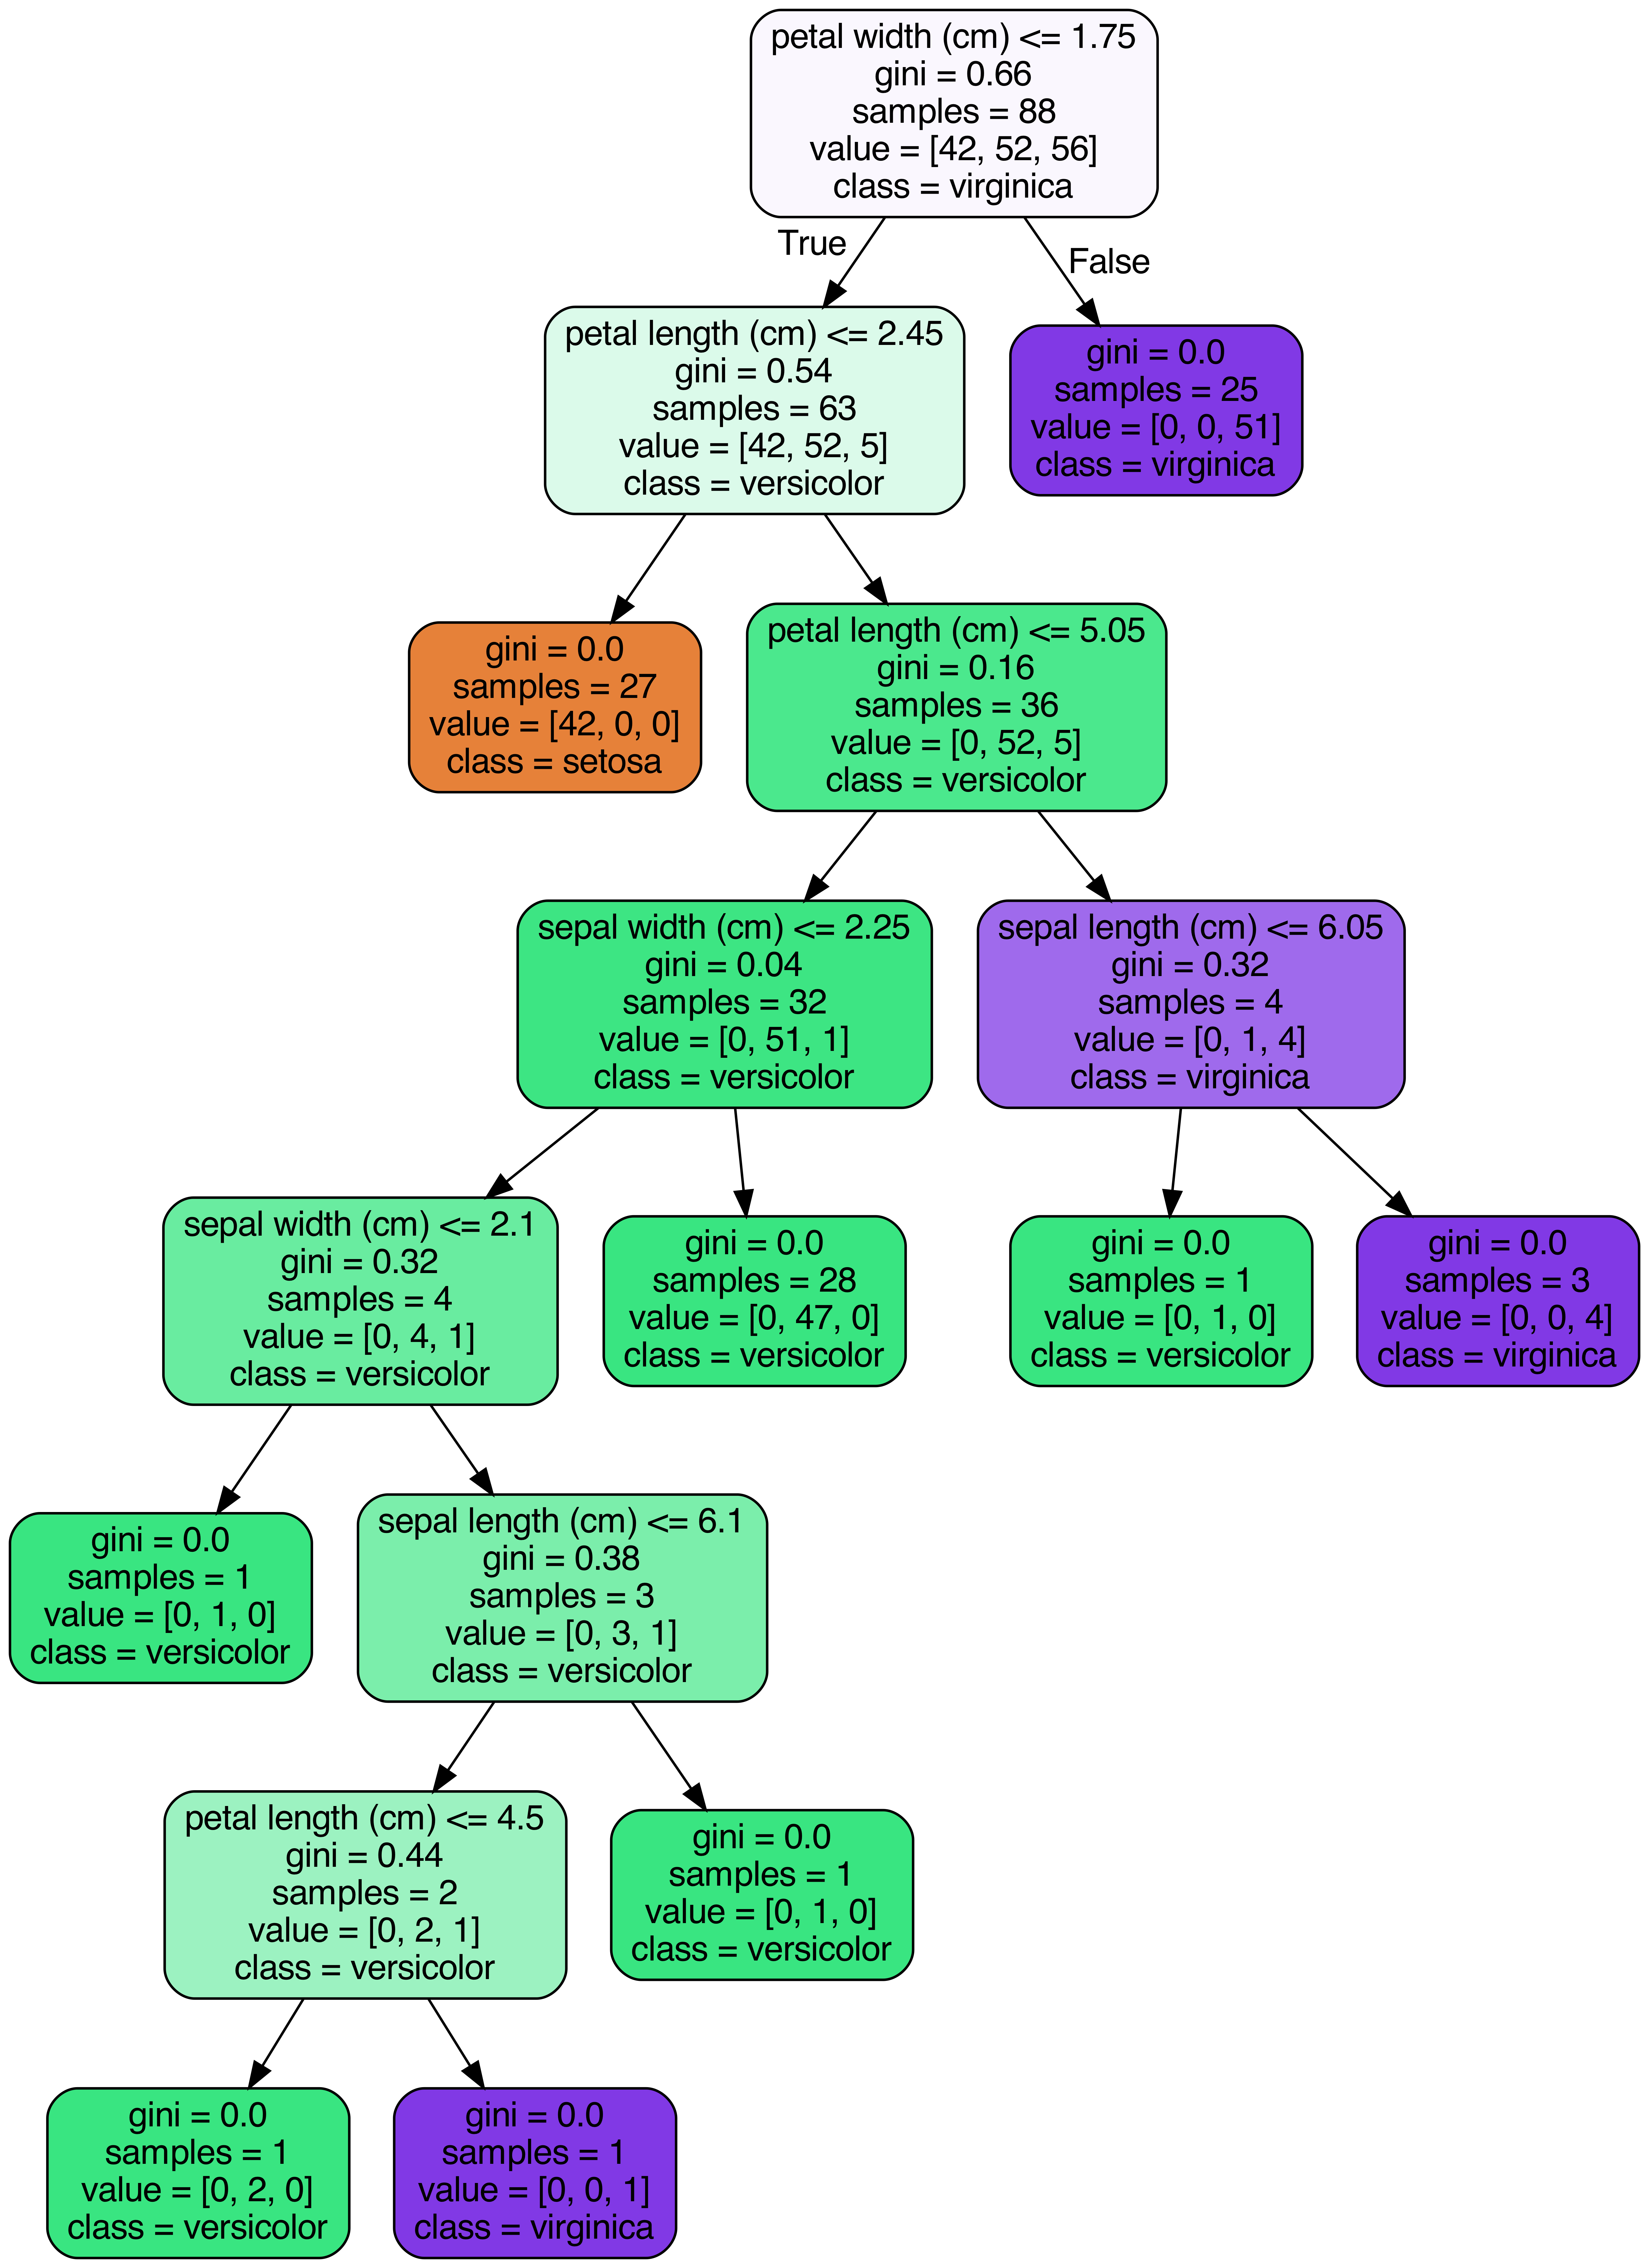

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
import missingno as msno

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
url ='/Users/lasayin/Desktop/Springboard/Unit14/14.4/Unit14.4_RandomForest Covid Case Study/SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [5]:
df.shape

(2218, 18)

In [6]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [7]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [8]:
df['n_age'] = 2020 - df.birth_year
df.n_age

0       56.0
1       33.0
2       56.0
3       29.0
4       28.0
        ... 
2213    30.0
2214    22.0
2215    22.0
2216    48.0
2217    46.0
Name: n_age, Length: 2218, dtype: float64

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [9]:
df.isna().sum()

patient_id               0
global_num             904
sex                    145
birth_year             454
age                    261
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [11]:
df.disease.value_counts()

True    19
Name: disease, dtype: int64

In [12]:
df.disease.fillna(0, inplace=True)
df.disease = df.disease.apply(lambda x: int(x))
#df.disease = df.disease*1
df.disease.value_counts()

0    2199
1      19
Name: disease, dtype: int64

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [13]:
df[['global_num', 'birth_year', 'infection_order', 'infected_by', 'contact_number']] = df[['global_num', 'birth_year', 'infection_order', 'infected_by', 'contact_number']].apply(lambda x: x.fillna(round(x.mean())))

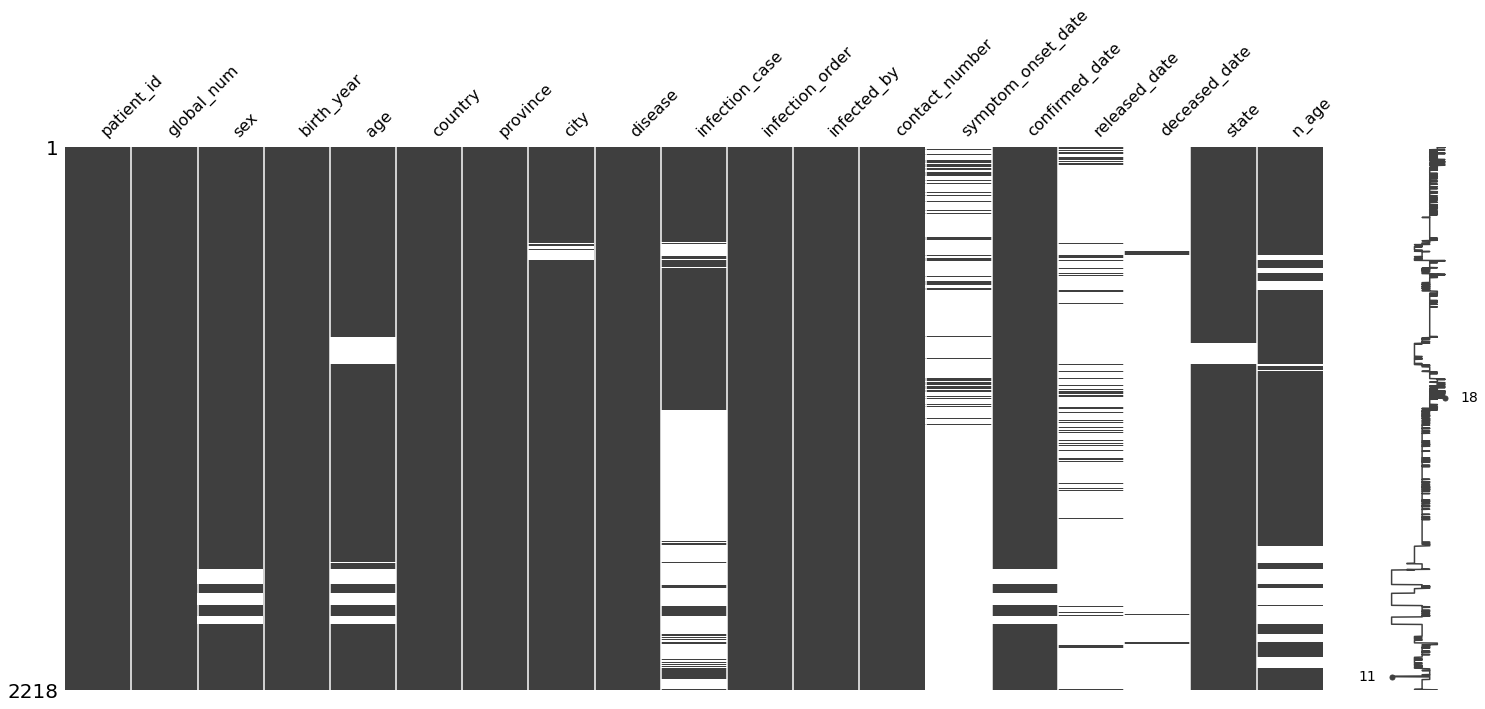

In [14]:
_ = msno.matrix(df)

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [15]:
df.sex.value_counts()

female    1171
male       902
Name: sex, dtype: int64

In [16]:
# Fill the missing values of sex in proportion to the sex ratio
index = df[df.sex.isna()].sex.sample(round(145*1171/(1171+902)), random_state=42).index
# Fill the sample with female
df.loc[index, 'sex'] = df.iloc[index].sex.fillna('female')
# Fill the rest with male
df.sex.fillna('male',inplace=True)
# Check the result
df.sex.value_counts()

female    1253
male       965
Name: sex, dtype: int64

In [17]:
df.age.unique()

array(['50s', '30s', '20s', '60s', '80s', '70s', '40s', '10s', '90s',
       '0s', nan, '100s'], dtype=object)

In [18]:
# Resign age by birth_year
df['age'] = df.birth_year.apply(lambda x: str(int((2020-x)//10)) + '0s')

# Alternatively
# ((2020-df.birth_year)//10).astype(int).astype(str) + '0s'

In [19]:
df.age.isna().sum()

0

In [20]:
# Check the provinces which have missing cities
provinces = df[df.city.isna()].province.unique()

for province in provinces:
    city_unique = df[df.province==province].city.unique()
    print(province)
    print(city_unique)
    
# All the entries from Gwangju have no city info

Busan
['Dongnae-gu' 'Haeundae-gu' 'Yeonje-gu' nan 'Buk-gu' 'Nam-gu' 'Seo-gu'
 'Geumjeong-gu' 'Saha-gu' 'Gangseo-gu' 'Suyeong-gu' 'Sasang-gu'
 'Busanjin-gu' 'etc']
Daegu
[nan 'Jung-gu' 'Nam-gu' 'Dalseo-gu' 'Dalseong-gun' 'Seo-gu' 'Suseong-gu'
 'Dong-gu']
Gwangju
[nan]
Jeollanam-do
[nan 'Suncheon-si' 'Yeosu-si' 'Gwangyang-si']
Gyeongsangnam-do
['Hapcheon-gun' 'Jinju-si' 'Changwon-si' 'Yangsan-si' 'Geoje-si'
 'Hamyang-gun' 'Goseong-gun' 'Gimhae-si' 'Namhae-gun' nan 'Geochang-gun'
 'Changnyeong-gun' 'Miryang-si']


In [21]:
# Check the mode of the cities from the provinces in the list, excluding Gwangju
province_list = ['Busan', 'Daegu', 'Jeollanam-do', 'Gyeongsangnam-do']
for province in province_list:
    print(province)
    print(df[df.province==province].city.mode())  
# There are more than one most frequent cities in Jeollanam-do

Busan
0    Dongnae-gu
dtype: object
Daegu
0    Nam-gu
dtype: object
Jeollanam-do
0    Gwangyang-si
1     Suncheon-si
2        Yeosu-si
dtype: object
Gyeongsangnam-do
0    Changwon-si
dtype: object


In [22]:
# Fill the missing values of the cities from the provinces in the list with mode
for province in province_list:
    city_mode = df[df.province==province].city.mode()[0]
    index=df[df.province==province].city.isna().index
    df.loc[index, 'city']=city_mode    

In [23]:
# Check result
df[df.city.isna()].province.value_counts()

Gwangju    18
Name: province, dtype: int64

In [24]:
# Fill the missing values of province Gwangju with Gwangju
df.city.fillna('Gwangju', inplace=True)
# Check result
df.city.isna().sum()

0

In [25]:
df.infection_case.value_counts()

contact with patient                530
etc                                 220
Guro-gu Call Center                 102
Shincheonji Church                   86
overseas inflow                      61
Onchun Church                        33
gym facility in Cheonan              30
Ministry of Oceans and Fisheries     27
Cheongdo Daenam Hospital             21
Dongan Church                        17
Eunpyeong St. Mary's Hospital        14
Seongdong-gu APT                     13
gym facility in Sejong                4
Suyeong-gu Kindergarten               3
River of Grace Community Church       1
Pilgrimage to Israel                  1
Name: infection_case, dtype: int64

In [26]:
# Fill missing values of infection_case with 'Unknown'

In [27]:
df.infection_case.fillna('Unknown', inplace=True)

In [28]:
# Check result
df.infection_case.value_counts()

Unknown                             1055
contact with patient                 530
etc                                  220
Guro-gu Call Center                  102
Shincheonji Church                    86
overseas inflow                       61
Onchun Church                         33
gym facility in Cheonan               30
Ministry of Oceans and Fisheries      27
Cheongdo Daenam Hospital              21
Dongan Church                         17
Eunpyeong St. Mary's Hospital         14
Seongdong-gu APT                      13
gym facility in Sejong                 4
Suyeong-gu Kindergarten                3
River of Grace Community Church        1
Pilgrimage to Israel                   1
Name: infection_case, dtype: int64

In [29]:
# Redefine n_age column according the birth_year column without missing values
df['n_age'] = 2020 - df.birth_year

In [30]:
# Drop all the entries with missing state
df.drop(index=df[df.state.isna()].index, inplace=True)
df.reset_index(drop=True, inplace=True)

 **<font color='teal'> Check for any remaining null values.</font>**

In [31]:
df.isna().sum()

patient_id               0
global_num               0
sex                      0
birth_year               0
age                      0
country                  0
province                 0
city                     0
disease                  0
infection_case           0
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    1943
confirmed_date         141
released_date         1907
deceased_date         2098
state                    0
n_age                    0
dtype: int64

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2130 entries, 0 to 2129
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2130 non-null   int64  
 1   global_num          2130 non-null   float64
 2   sex                 2130 non-null   object 
 3   birth_year          2130 non-null   float64
 4   age                 2130 non-null   object 
 5   country             2130 non-null   object 
 6   province            2130 non-null   object 
 7   city                2130 non-null   object 
 8   disease             2130 non-null   int64  
 9   infection_case      2130 non-null   object 
 10  infection_order     2130 non-null   float64
 11  infected_by         2130 non-null   float64
 12  contact_number      2130 non-null   float64
 13  symptom_onset_date  187 non-null    object 
 14  confirmed_date      1989 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

In [33]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,56.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,NaN,2020-01-30,2020-03-02,NaN,released,33.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,56.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,29.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,28.0


Remove date columns from the data.


In [34]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [35]:
print(df.nunique())

patient_id         2130
global_num         1224
sex                   2
birth_year           96
age                  11
country               4
province             17
city                111
disease               2
infection_case       17
infection_order       6
infected_by         196
contact_number       72
state                 3
n_age                96
dtype: int64


Review the percent of unique values by column.

In [36]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.574648
sex                0.000939
birth_year         0.045070
age                0.005164
country            0.001878
province           0.007981
city               0.052113
disease            0.000939
infection_case     0.007981
infection_order    0.002817
infected_by        0.092019
contact_number     0.033803
state              0.001408
n_age              0.045070
dtype: float64


Convert age to float type

In [37]:
df.age = pd.to_numeric(df.age.str.replace('s',''))

Review the range of values per column.

In [38]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2130.0,4.095989e+09,2.197921e+09,1.000000e+09,1.600000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2130.0,4.526560e+03,2.137673e+03,1.000000e+00,4.051250e+03,4.665000e+03,5.445500e+03,8.717000e+03
birth_year,2130.0,1.974939e+03,1.728608e+01,1.916000e+03,1.965000e+03,1.975000e+03,1.988000e+03,2.020000e+03
age,2130.0,4.058216e+01,1.732021e+01,0.000000e+00,3.000000e+01,4.000000e+01,5.000000e+01,1.000000e+02
disease,2130.0,8.920188e-03,9.404664e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2130.0,2.005634e+00,1.786285e-01,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,6.000000e+00
infected_by,2130.0,2.620626e+09,7.269510e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2130.0,2.404131e+01,3.996895e+01,0.000000e+00,2.400000e+01,2.400000e+01,2.400000e+01,1.160000e+03
n_age,2130.0,4.506056e+01,1.728608e+01,0.000000e+00,3.200000e+01,4.500000e+01,5.500000e+01,1.040000e+02


### Check for duplicated rows

In [39]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [40]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
print(dfo.shape)
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

(2130, 6)


,VarName,LevelsCount
0,sex,2
1,country,4
2,province,17
3,city,111
4,infection_case,17
5,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

In [41]:
df.dtypes

patient_id           int64
global_num         float64
sex                 object
birth_year         float64
age                  int64
country             object
province            object
city                object
disease              int64
infection_case      object
infection_order    float64
infected_by        float64
contact_number     float64
state               object
n_age              float64
dtype: object

In [42]:
dff = df.select_dtypes(include='float64')
dff

,global_num,birth_year,infection_order,infected_by,contact_number,n_age
0,2.0,1964.0,1.0,2.600789e+09,75.0,56.0
1,5.0,1987.0,1.0,2.600789e+09,31.0,33.0
2,6.0,1964.0,2.0,2.002000e+09,17.0,56.0
3,7.0,1991.0,1.0,2.600789e+09,9.0,29.0
4,9.0,1992.0,2.0,1.000000e+09,2.0,28.0
...,...,...,...,...,...,...
2125,4665.0,1971.0,2.0,2.600789e+09,24.0,49.0
2126,139.0,1998.0,2.0,2.600789e+09,87.0,22.0
2127,222.0,1998.0,2.0,2.600789e+09,84.0,22.0
2128,4345.0,1972.0,2.0,2.600789e+09,21.0,48.0


**<font color='teal'> Plot the boxplots to check for outliers. </font>**

global_num            AxesSubplot(0.125,0.536818;0.227941x0.343182)
birth_year         AxesSubplot(0.398529,0.536818;0.227941x0.343182)
infection_order    AxesSubplot(0.672059,0.536818;0.227941x0.343182)
infected_by              AxesSubplot(0.125,0.125;0.227941x0.343182)
contact_number        AxesSubplot(0.398529,0.125;0.227941x0.343182)
n_age                 AxesSubplot(0.672059,0.125;0.227941x0.343182)
dtype: object

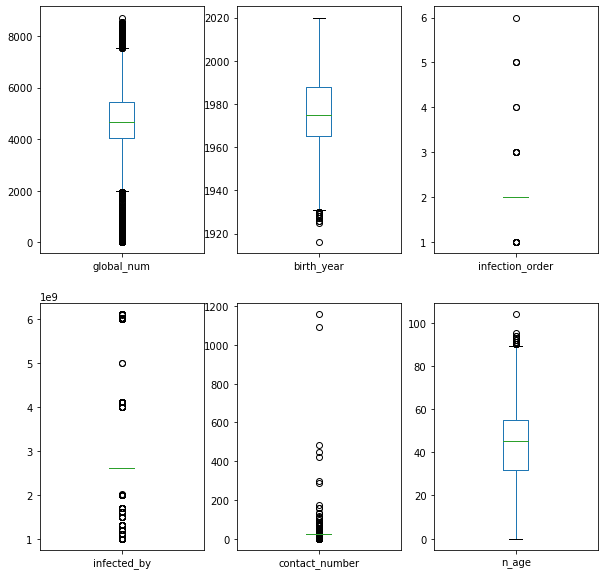

In [43]:
dff.plot(kind='box', subplots=True, layout=(2,3), figsize=(10,10))

**<font color='teal'> Create dummy features for object type features. </font>**

In [44]:
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

In [45]:
pd.get_dummies(dfo)

,sex_female,sex_male,country_China,country_Korea,country_Mongolia,country_Thailand,province_Busan,province_Chungcheongbuk-do,province_Chungcheongnam-do,province_Daegu,...,infection_case_Suyeong-gu Kindergarten,infection_case_Unknown,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow,state_deceased,state_isolated,state_released
0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,0,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2126,0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2127,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2128,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [46]:
dfo

,sex,country,province,city,infection_case,state
0,male,Korea,Seoul,Gangseo-gu,overseas inflow,released
1,male,Korea,Seoul,Jungnang-gu,overseas inflow,released
2,male,Korea,Seoul,Jongno-gu,contact with patient,released
3,male,Korea,Seoul,Mapo-gu,overseas inflow,released
4,female,Korea,Seoul,Seongbuk-gu,contact with patient,released
...,...,...,...,...,...,...
2125,male,Korea,Gyeongsangnam-do,Changwon-si,Unknown,isolated
2126,male,Korea,Jeju-do,Jeju-do,etc,isolated
2127,female,Korea,Jeju-do,Jeju-do,etc,released
2128,female,Korea,Jeju-do,etc,etc,released


### Split the data into test and train subsamples

In [47]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

NameError: name 'X' is not defined

### Scale data to prep for model creation

In [ ]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [ ]:
class_names=['isolated','released','missing','deceased'] # name  of classes

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

In [ ]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.